In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from tensorflow import keras
from keras.layers import *
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

2025-12-30 11:45:07.179157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767095107.343591      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767095107.393020      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767095107.784969      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767095107.785013      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767095107.785016      55 computation_placer.cc:177] computation placer alr

In [2]:
dataset_path = '/kaggle/input/utkface-new/UTKFace'

# Convert data into raw and column format 

In [3]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dataset_path)):
    image_path = os.path.join(dataset_path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


100%|██████████| 23708/23708 [00:00<00:00, 522052.96it/s]


# Create DataFrame

In [4]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


# Check your image data

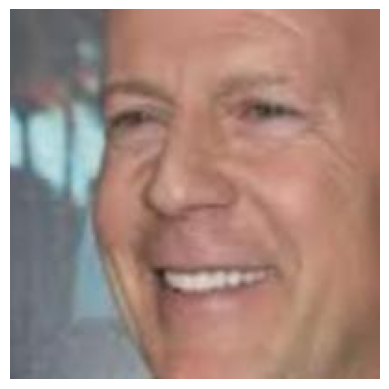

In [5]:
from PIL import Image
img = Image.open(df['image'][12])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

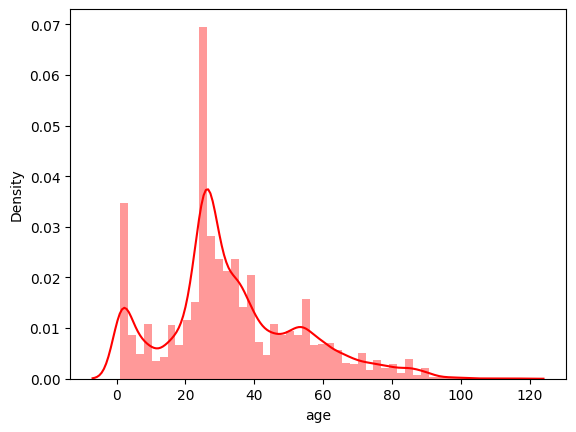

In [6]:
sns.distplot(df['age'], color = 'red')

In the Above diagram we can see our data content major part of images whose person their ages around 20 to 40. because that our will perform well on whose their age is same. because out data does not centroid.

# Extract the features of images

In [7]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode = 'rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [8]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [01:52<00:00, 210.15it/s]


In [9]:
X.shape

(23708, 128, 128, 3)

In [10]:
X = X/255.0

In [11]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [12]:
input_shape = (128,128,3)

# CNN MODEL

In [13]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size = (3,3), activation = None)(inputs)
x = BatchNormalization()(conv_1)
x = ReLU()(x)
maxp1 = MaxPooling2D(pool_size = (2,2))(x)

conv_2 = Conv2D(64, kernel_size = (3,3), activation = None)(maxp1)
x = BatchNormalization()(conv_2)
x = ReLU()(x)
maxp2 = MaxPooling2D(pool_size = (2,2))(x)

conv_3 = Conv2D(128, kernel_size = (3,3), activation = None)(maxp2)
x = BatchNormalization()(conv_3)
x = ReLU()(x)
maxp3 = MaxPooling2D(pool_size = (2,2))(x)

conv_4 = Conv2D(256, kernel_size = (3,3), activation = None)(maxp3)
x = BatchNormalization()(conv_4)
x = ReLU()(x)
maxp4 = MaxPooling2D(pool_size = (2,2))(x)

flatten = Flatten()(maxp4)

dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_2)

output_1 = Dense(1, activation = 'sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name='age_out')(dropout_2)

model = Model(inputs = [inputs], outputs =  [output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy','mae'])


I0000 00:00:1767095334.393720      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767095334.397703      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


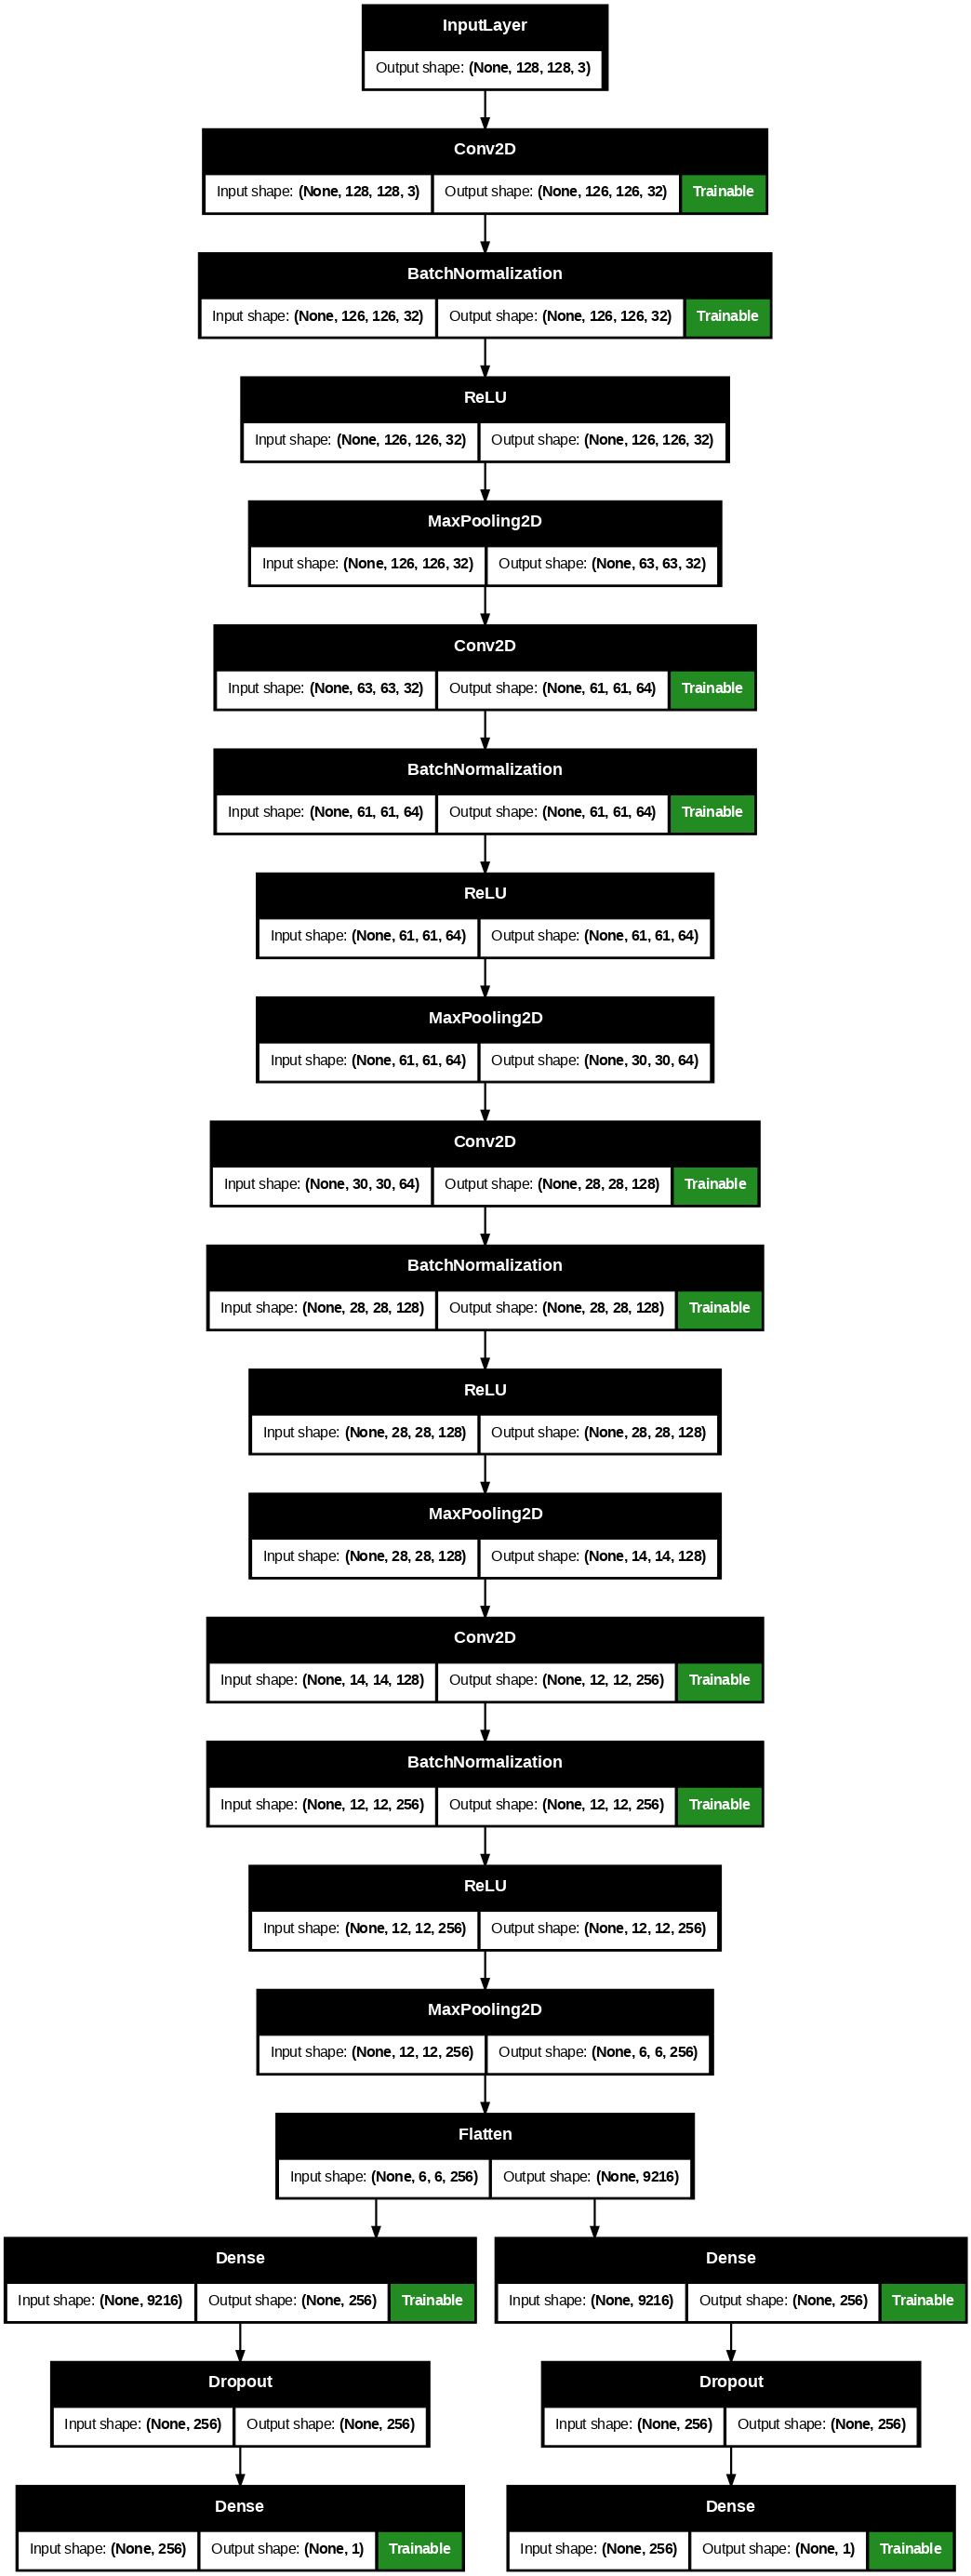

In [14]:
plot_model(
    model,
    show_shapes = True,
    dpi = 80,
    show_trainable = True
)

In [15]:
history = model.fit(x = X, y = [y_gender, y_age], batch_size = 32, epochs = 30, validation_split = 0.2)

Epoch 1/30


I0000 00:00:1767095368.256686     143 service.cc:152] XLA service 0x7fbfec00ff90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767095368.256742     143 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767095368.256749     143 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767095369.069632     143 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-30 11:49:31.108734: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-30 11:49:31.256734: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  5/593 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - age_out_loss: 29.7797 - age_out_mae: 29.7797 - gender_out_accuracy: 0.4402 - gender_out_loss: 10.0574 - loss: 39.8372

I0000 00:00:1767095375.175321     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - age_out_loss: 13.6483 - age_out_mae: 13.6483 - gender_out_accuracy: 0.6905 - gender_out_loss: 1.0807 - loss: 14.7291 - val_age_out_loss: 16.3896 - val_age_out_mae: 16.3993 - val_gender_out_accuracy: 0.7849 - val_gender_out_loss: 0.4429 - val_loss: 16.8432
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - age_out_loss: 9.5565 - age_out_mae: 9.5565 - gender_out_accuracy: 0.8142 - gender_out_loss: 0.4035 - loss: 9.9600 - val_age_out_loss: 11.1083 - val_age_out_mae: 11.0857 - val_gender_out_accuracy: 0.8446 - val_gender_out_loss: 0.3963 - val_loss: 11.4822
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - age_out_loss: 8.6451 - age_out_mae: 8.6451 - gender_out_accuracy: 0.8310 - gender_out_loss: 0.3627 - loss: 9.0078 - val_age_out_loss: 7.5445 - val_age_out_mae: 7.5609 - val_gender_out_accuracy: 0.8475 - val_gender_out_loss: 0.3232 - val_loss: 7.8845
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - age_out_loss: 8.3874 - age_o

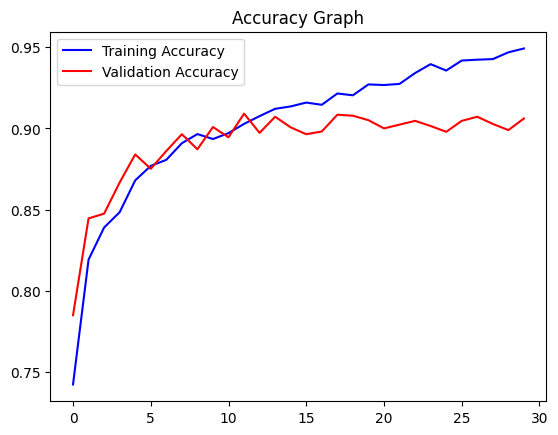

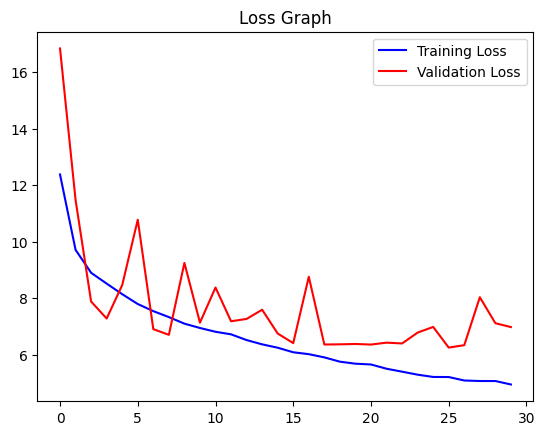

In [16]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

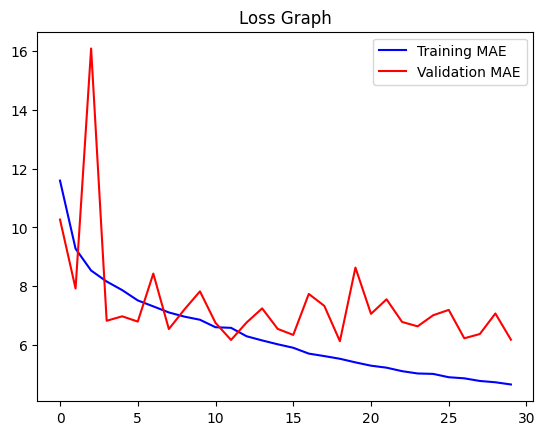

In [ ]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [17]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))